In [1]:
import dateparser
import pickle
import requests

from datetime import datetime
from io import BytesIO

import pandas as pd

from bs4 import BeautifulSoup

class DividendDataDownloader:
    """Download the data from Dividata.com and save it as a pickle"""

    def __init__(self, ticker, pickled_name=None):
        """
        Initialize the class with the input parameters
        :param str ticker: ticker to download and to collect the data from
        :param str pickled_name: name of the pickled_file to be processed
        """
        self.__ticker = ticker
        self.__results = None
        print(f'Getting dividend data for ticker {ticker}...')
        self.__html_downloaded_table = self.__parse_div_data_from_dividata(ticker)
        if self.__html_downloaded_table:
            self.__results = self.__build_json_table(self.__html_downloaded_table)
        if pickled_name:
            self.__write_data_to_pickle(pickled_name)

    def __parse_div_data_from_dividata(self, ticker):
        """
        Parse the data from dividata.com and store it in memory
        :param str ticker: ticker to be processed
        :return: a JSON Object with all the available data
        :rtype: dict or None
        """
        web_address = f'https://dividata.com/stock/{ticker.lower()}/dividend'
        downloaded_web_page = requests.get(web_address)
        soup = BeautifulSoup(downloaded_web_page.text, 'html.parser')
        table = soup.find("table", class_="table table-striped table-hover")
        try:
            parsed_table = self.__get_table_data(table)
        except AttributeError:
            print(f'It seems that {ticker} has never paid a dividend. Nothing to download.')
            return None
        return parsed_table

    def __get_table_data(self, table_object):
        """
        Take the parsed tags, read and catalog them
        :param bs4.element.Tag table_object: BS4 Table Object
        :return: a dictionary with headers and rows lists as properties
        :rtype: dict
        """
        table_rows = table_object.findAll('tr')
        output_rows = list()
        for table_row in table_rows:
            columns = table_row.findAll('td')
            output_row = list()
            for column in columns:
                output_row.append(column.text.strip())
            if not output_row:
                continue
            output_rows.append(output_row)
        table_data = {'headers': ["Ex-Dividend Date", "Dividend Amount"], 'rows': output_rows}
        return table_data

    def __format_table_content(self, row_list):
        """
        Remove the Dollar sign implicitly converting the amount in numbers and converts the dates to datetime
        :param list row_list: list of rows with format [Ex-Div Date, Amount]
        :return: a list of rows with the same format in input and a numeric amount
        :rtype: list
        """
        for row in row_list:
            try:
                row[0] = dateparser.parse(row[0])
                row[1] = float(row[1].split("$")[1])
            except IndexError:
                row[1] = 0
        return row_list

    def __build_json_table(self, parsed_table_data):
        """
        Build the JSON Table starting from the parsed data
        :param dict parsed_table_data: dictionary with the headers and the rows data
        :return: a converted JSON object
        :rtype: list
        """
        headers = parsed_table_data.get('headers', {})
        rows = self.__format_table_content(parsed_table_data.get('rows', {}))
        json_results = [dict(zip(headers, row)) for row in rows]
        return json_results

    def __write_data_to_pickle(self, filename):
        """
        Pickle the data to work offline
        :param str filename: filename of the desired pickle output
        :return: a pickled file
        :rtype: None
        """
        pickle.dump(self.__results, open(filename, 'wb'))

    def get_results(self):
        """
        Get the private variable where are stored all the results and return it
        :return: the parsed JSON results
        :rtype: dict
        """
        return self.__results

    def get_results_as_df(self):
        """
        Get the results in a DataFrame format
        :return: converted DataFrame results
        :rtype: pd.DataFrame
        """
        return pd.DataFrame(self.__results)

In [62]:
ticker = "AAPL"
divdata = DividendDataDownloader(ticker).get_results_as_df()
if not divdata.empty:
    divdata = divdata[divdata["Dividend Amount"] > 0]
    divdata.sort_index(ascending=False, inplace=True)
    if len(divdata) > 20:
        divdata = divdata.iloc[-20:]
else:
    print("It seems the stock has never paid dividends.")

Getting dividend data for ticker AAPL...


In [63]:
divdata

,Ex-Dividend Date,Dividend Amount
19,2015-08-06,0.52
18,2015-11-05,0.52
17,2016-02-04,0.52
16,2016-05-05,0.57
15,2016-08-04,0.57
14,2016-11-03,0.57
13,2017-02-09,0.57
12,2017-05-11,0.63
11,2017-08-10,0.63
10,2017-11-10,0.63


In [64]:
def annualize_divideds(df):
    tail = df.tail(4)
    august_date = dateparser.parse("-".join([str(tail.loc[0]["Ex-Dividend Date"].year), "08", "01"]))
    november_date = dateparser.parse("-".join([str(tail.loc[0]["Ex-Dividend Date"].year), "11", "01"]))
    february_date = dateparser.parse("-".join([str(tail.loc[0]["Ex-Dividend Date"].year + 1), "02", "01"]))
    dates = [august_date, november_date, february_date]
    idx = 0
    if tail.loc[0]["Ex-Dividend Date"].month in [1, 2, 3]:
        return df
    elif tail.loc[0]["Ex-Dividend Date"].month in [4, 5, 6]:
        idx = 3
    elif tail.loc[0]["Ex-Dividend Date"].month in [7, 8, 9]:
        idx = 2
    else:
        idx = 1
    for i in range(0, idx):
        df = df.append({"Ex-Dividend Date": dates[i], "Dividend Amount": tail.loc[0]["Dividend Amount"]}, ignore_index=True)
    return df
        
divdata = annualize_divideds(divdata)
divdata

,Ex-Dividend Date,Dividend Amount
0,2015-08-06,0.52
1,2015-11-05,0.52
2,2016-02-04,0.52
3,2016-05-05,0.57
4,2016-08-04,0.57
5,2016-11-03,0.57
6,2017-02-09,0.57
7,2017-05-11,0.63
8,2017-08-10,0.63
9,2017-11-10,0.63


In [65]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg

series = divdata["Dividend Amount"]
X = series.values
cutoff_idx = round(len(X) * 0.25)
train, test = X[:-cutoff_idx], X[-cutoff_idx:]

In [66]:
model = AutoReg(train, lags=4, old_names=False)
model_fit = model.fit()
predictions = model_fit.predict(start=len(X), end=len(X)+len(test)-1, dynamic=False)
rmse = sqrt(mean_squared_error(test, predictions))
rmse

0.17796300421165456

In [67]:
predictions = model_fit.predict(start=len(X), end=len(X) + 3)
average_predictions = predictions.mean()
annualized_prediction = list([round(average_predictions, 2)]) * 4
annualized_prediction

[0.96, 0.96, 0.96, 0.96]

In [68]:
from datetime import timedelta

dates = divdata["Ex-Dividend Date"].iloc[-4:].tolist()
dates = [i + timedelta(days=365) for i in dates]
divdata = divdata.append(pd.DataFrame({"Ex-Dividend Date": dates, "Dividend Amount": annualized_prediction}), ignore_index=True)
divdata.set_index("Ex-Dividend Date", inplace=True)
divdata

,Dividend Amount
Ex-Dividend Date,
2015-08-06,0.52
2015-11-05,0.52
2016-02-04,0.52
2016-05-05,0.57
2016-08-04,0.57
2016-11-03,0.57
2017-02-09,0.57
2017-05-11,0.63
2017-08-10,0.63


<AxesSubplot:title={'center':'AAPL Dividend Forecast 1-Year'}, xlabel='Ex-Dividend Date'>

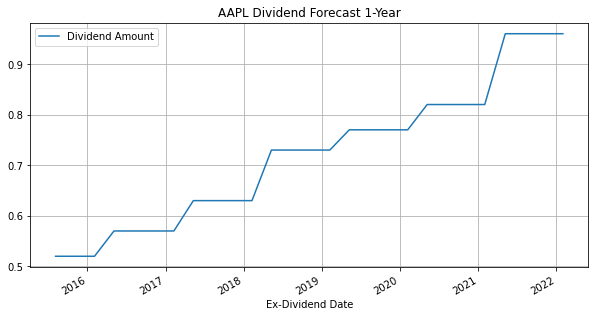

In [69]:
divdata.plot(figsize=(10,5), grid=True, title=f"{ticker} Dividend Forecast 1-Year")